In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "politician"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(5908, 16)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

5908

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(5908, 1)


,label
index,
0,1
1,5
2,7
3,12
4,10


### Diffusion Modeling

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.30574478510952025

In [8]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [9]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 4413 0.9974884723008519
0.9974884723008519
1 4896 0.9984128515538626
0.9984128515538627
1 5471 0.9945242422861698
0.9945242422861698
1 3531 0.9946260411006532
0.9946260411006532
1 1965 0.9831698357962538
0.9831698357962537
1 2565 0.9861203336882424
0.9861203336882423
1 3317 0.997821762432456
0.9978217624324561
1 5565 0.9956677304241629
0.995667730424163
1 2448 0.9949684810476138
0.9949684810476139
1 955 0.9823198512929074
0.9823198512929076
1 3699 0.9965423514695567
0.9965423514695568
1 519 0.981452697271177
0.981452697271177
1 3849 0.9947623023575536
0.9947623023575536
1 5557 0.9827299777093296
0.9827299777093297
1 1618 0.9945322452970689
0.9945322452970689
1 3779 0.3871626684839132
0.3871626684839131
1 3550 0.9951758002351397
0.9951758002351399
1 3866 0.9831429459777503
0.9831429459777503
1 5729 0.9844633610423364
0.9844633610423364


In [10]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    prev = len(seeds)
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            if j % (len(df_emb) // 1000) == 0:
                df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : cosine(df_emb.iloc[source], df_emb.iloc[x]) > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 1000 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(np.unique(df_edges.node_2))))
                
    return df_history, df_infected

### Random Seeds

In [11]:
n_seeds = 60

In [12]:
seeds = np.random.choice(df_emb.index, n_seeds)

df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/60, infected 60 (1.23%)     
iteration 1, progress 0/299, infected 319 (6.51%)     
iteration 2, progress 0/913, infected 914 (18.66%)     
iteration 3, progress 0/1396, infected 1396 (28.51%)     
iteration 3, progress 1000/1396, infected 1769 (36.12%)     
iteration 4, progress 0/1778, infected 1778 (36.31%)     
iteration 4, progress 1000/1778, infected 1923 (39.27%)     
iteration 5, progress 0/1943, infected 1943 (39.68%)     
iteration 5, progress 1000/1943, infected 2044 (41.74%)     
iteration 6, progress 0/2060, infected 2060 (42.07%)     
iteration 6, progress 1000/2060, infected 2094 (42.76%)     
iteration 6, progress 2000/2060, infected 2104 (42.97%)     
iteration 7, progress 0/2104, infected 2104 (42.97%)     
iteration 7, progress 1000/2104, infected 2126 (43.41%)     
iteration 7, progress 2000/2104, infected 2130 (43.50%)     
iteration 8, progress 0/2130, infected 2130 (43.50%)     
iteration 8, progress 1000/2130, infected 2139 (43.68%)     


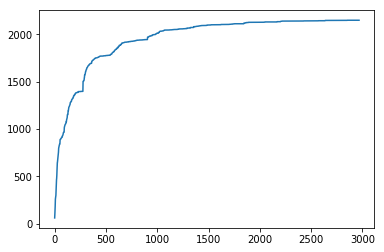

In [14]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [16]:
df_history.iloc[:, :].to_csv("outputs/%s_random.csv"%dataset)

### Influencers

In [17]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/60, infected 110 (2.25%)     
iteration 1, progress 0/1680, infected 1680 (34.31%)     
iteration 1, progress 1000/1680, infected 2432 (49.66%)     
iteration 2, progress 0/2502, infected 2502 (51.09%)     
iteration 2, progress 1000/2502, infected 2767 (56.50%)     
iteration 2, progress 2000/2502, infected 2881 (58.83%)     
iteration 3, progress 0/2898, infected 2898 (59.18%)     
iteration 3, progress 1000/2898, infected 3070 (62.69%)     
iteration 3, progress 2000/2898, infected 3157 (64.47%)     
iteration 4, progress 0/3186, infected 3186 (65.06%)     
iteration 4, progress 1000/3186, infected 3273 (66.84%)     
iteration 4, progress 2000/3186, infected 3331 (68.02%)     
iteration 4, progress 3000/3186, infected 3351 (68.43%)     
iteration 5, progress 0/3353, infected 3353 (68.47%)     
iteration 5, progress 1000/3353, infected 3381 (69.04%)     
iteration 5, progress 2000/3353, infected 3427 (69.98%)     
iteration 5, progress 3000/3353, infected 3433

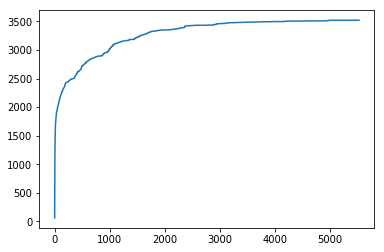

In [18]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [19]:
df_history.iloc[:, :].to_csv("outputs/%s_influencer.csv"%dataset)

### Cluster Random Seeds

In [20]:
n_classes = len(np.unique(df_label.label))

In [21]:
for target in range(n_classes):
    print(target, "cluster size", sum(df_label.label==target))

0 cluster size 184
1 cluster size 319
2 cluster size 359
3 cluster size 154
4 cluster size 357
5 cluster size 238
6 cluster size 284
7 cluster size 205
8 cluster size 377
9 cluster size 203
10 cluster size 375
11 cluster size 330
12 cluster size 537
13 cluster size 552
14 cluster size 217
15 cluster size 163
16 cluster size 253
17 cluster size 249
18 cluster size 115
19 cluster size 437


In [22]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [23]:
seeds = [int(i) for i in seeds]
len(seeds)

61

In [24]:
df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/61, infected 61 (1.25%)     
iteration 1, progress 0/500, infected 500 (10.21%)     
iteration 2, progress 0/1456, infected 1456 (29.73%)     
iteration 2, progress 1000/1456, infected 1880 (38.39%)     
iteration 3, progress 0/1921, infected 1921 (39.23%)     
iteration 3, progress 1000/1921, infected 2105 (42.99%)     
iteration 4, progress 0/2151, infected 2151 (43.92%)     
iteration 4, progress 1000/2151, infected 2267 (46.29%)     
iteration 4, progress 2000/2151, infected 2305 (47.07%)     
iteration 5, progress 0/2305, infected 2305 (47.07%)     
iteration 5, progress 1000/2305, infected 2372 (48.44%)     
iteration 5, progress 2000/2305, infected 2392 (48.85%)     
iteration 6, progress 0/2393, infected 2393 (48.87%)     
iteration 6, progress 1000/2393, infected 2409 (49.19%)     
iteration 6, progress 2000/2393, infected 2416 (49.34%)     
iteration 7, progress 0/2418, infected 2418 (49.38%)     
iteration 7, progress 1000/2418, infected 2424 (49.50%)

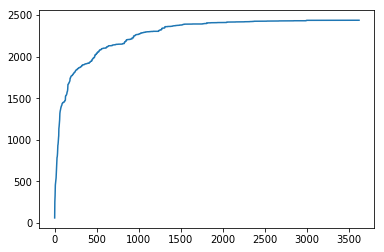

In [25]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [26]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_random.csv"%dataset)

### Cluster Influencer

In [27]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    cluster_n_seeds = round(n_seeds * len(np.unique(df_cluster.index)) / len(df_emb))
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    cluster_seeds = list(df_influencer.sort_values(["node_2"], ascending=False)[:cluster_n_seeds].index.values)
    seeds += cluster_seeds

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [28]:
df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/61, infected 95 (1.94%)     
iteration 1, progress 0/2355, infected 2355 (48.09%)     
iteration 1, progress 1000/2355, infected 3264 (66.65%)     
iteration 1, progress 2000/2355, infected 3450 (70.45%)     
iteration 2, progress 0/3466, infected 3466 (70.78%)     
iteration 2, progress 1000/3466, infected 3626 (74.05%)     
iteration 2, progress 2000/3466, infected 3732 (76.21%)     
iteration 2, progress 3000/3466, infected 3770 (76.99%)     
iteration 3, progress 0/3776, infected 3776 (77.11%)     
iteration 3, progress 1000/3776, infected 3823 (78.07%)     
iteration 3, progress 2000/3776, infected 3846 (78.54%)     
iteration 3, progress 3000/3776, infected 3857 (78.76%)     
iteration 4, progress 0/3861, infected 3861 (78.84%)     
iteration 4, progress 1000/3861, infected 3874 (79.11%)     
iteration 4, progress 2000/3861, infected 3888 (79.40%)     
iteration 4, progress 3000/3861, infected 3895 (79.54%)     
iteration 5, progress 0/3895, infected 3895 

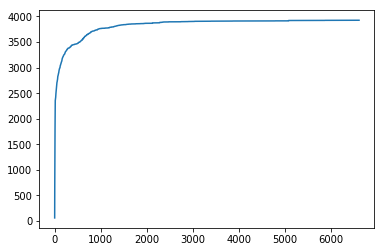

In [29]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [30]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_influencer.csv"%dataset)

### Stratified Sampling by Influence

In [ ]:
# df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
# df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
# len(df_influencer)

In [ ]:
# n_strata = 32
# _ = plt.hist(df_influencer.node_2, bins=n_strata)
# strata_size, strata_bound = _[0], _[1]
# # plt.close()

In [ ]:
# strata_sizes = list(map(round, strata_size))
# strata_bounds = list(map(round, strata_bound))

In [ ]:
# seeds = []
# for i in range(n_strata):
#     l, r = strata_bounds[i], strata_bounds[i + 1]
#     strata_size = int(strata_sizes[i])
#     df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
#     cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
#     cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    
#     seeds += cluster_seeds
# print(len(seeds))

In [ ]:
# df_history, df_infected = simulate_diffusion(seeds, iteration=5)

In [ ]:
# df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
# df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
# plt.plot(df_sum.values)